In [25]:
# Bem vindo ao meu projeto de IC

In [26]:
# Esse projeto engloba a análise e Estudo das bibliotecas OpenCv e MediaPipe para captura de movimentos do corpo.

In [27]:
# Importando as bibliotecas para uso

import cv2
import mediapipe as mp
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# Função auxiliar para calcular estabilidade dos pontos
def calc_stability(prev_landmarks, curr_landmarks):
    if prev_landmarks is None or curr_landmarks is None:
        return None

    diffs = [
        np.linalg.norm(np.array([pl.x, pl.y]) - np.array([cl.x, cl.y]))
        for pl, cl in zip(prev_landmarks, curr_landmarks)
    ]
    
    return np.mean(diffs)

In [29]:
configs = [
    {"name": "Alta precisão", "model_complexity": 2, "smooth_landmarks": True},
    {"name": "Média precisão", "model_complexity": 1, "smooth_landmarks": True},
    {"name": "Baixa precisão (alta velocidade)", "model_complexity": 0, "smooth_landmarks": False},
]

In [30]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [31]:
for config in configs:
    print(f"\n Testando configuração: {config['name']}")

    cap = cv2.VideoCapture(0)
    pose = mp_pose.Pose(
        static_image_mode=False,
        # Defini valor o model_complexity com 1, 2 e tals.
        model_complexity=config["model_complexity"],
        enable_segmentation=False,
        # Aqui também definido como true ou não, isso é uma suavização que é feito entre os frames, deixando mais estável, mas mais lento
        smooth_landmarks=config["smooth_landmarks"],
        # Mínimo para detectar alguém, valor médio
        min_detection_confidence=0.5,
        # Mínimo para continuar seguindo a movimentação de alguém, valor médio
        min_tracking_confidence=0.5
    )

    prev_time = 0
    prev_landmarks = None
    stabilities = []
    fps_values = []

    csv_name = f"landmarks_{config['name'].replace(' ', '_')}.csv"
    with open(csv_name, mode="w", newline="") as file:
        writer = csv.writer(file)
        header = ["frame", "landmark_index", "x", "y", "z", "visibility"]
        writer.writerow(header)

        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb)

            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
                )

                for i, lm in enumerate(results.pose_landmarks.landmark):
                    writer.writerow([frame_count, i, lm.x, lm.y, lm.z, lm.visibility])

                stability = calc_stability(prev_landmarks, results.pose_landmarks.landmark)
                if stability is not None:
                    stabilities.append(stability)

                prev_landmarks = results.pose_landmarks.landmark

            curr_time = time.time()
            fps = 1 / (curr_time - prev_time) if prev_time else 0
            prev_time = curr_time
            fps_values.append(fps)

            cv2.putText(frame, f"FPS: {int(fps)}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            cv2.imshow(config["name"], frame)
            frame_count += 1

            if cv2.waitKey(1) & 0xFF == 27:
                break
        
        no_detection_frames = 0
        if not results.pose_landmarks:
            no_detection_frames += 1

        total_frames = frame_count
        print(f"Frames sem detecção: {no_detection_frames}/{total_frames} ({no_detection_frames/total_frames*100:.2f}%)")


    cap.release()
    pose.close()
    cv2.destroyAllWindows()

    if fps_values and stabilities:
        print(f"FPS médio: {np.mean(fps_values):.2f}")
        print(f"Estabilidade média dos landmarks: {np.mean(stabilities):.5f}")
        print(f"CSV salvo em: {csv_name}")
    else:
        print("Nenhum dado coletado.")


 Testando configuração: Alta precisão
Frames sem detecção: 0/10 (0.00%)
FPS médio: 7.50
Estabilidade média dos landmarks: 0.00635
CSV salvo em: landmarks_Alta_precisão.csv

 Testando configuração: Média precisão
Frames sem detecção: 0/26 (0.00%)
FPS médio: 19.83
Estabilidade média dos landmarks: 0.00679
CSV salvo em: landmarks_Média_precisão.csv

 Testando configuração: Baixa precisão (alta velocidade)
Frames sem detecção: 0/17 (0.00%)
FPS médio: 20.78
Estabilidade média dos landmarks: 0.01468
CSV salvo em: landmarks_Baixa_precisão_(alta_velocidade).csv


In [34]:

#=== Testando configuração: Alta precisão ===
#FPS médio: 4.71
#Estabilidade média dos landmarks: 0.04507
#CSV salvo em: landmarks_Alta_precisão.csv
#
#=== Testando configuração: Média precisão ===
#FPS médio: 22.24
#Estabilidade média dos landmarks: 0.01965
#CSV salvo em: landmarks_Média_precisão.csv
#
#=== Testando configuração: Baixa precisão (alta velocidade) ===
#FPS médio: 26.90
#Estabilidade média dos landmarks: 0.04616
#CSV salvo em: landmarks_Baixa_precisão_(alta_velocidade).csv

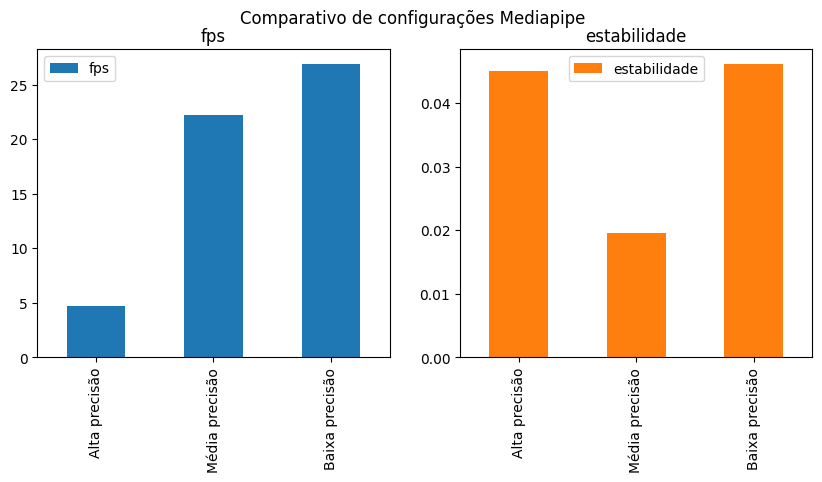

In [35]:
resultados = {
    "Alta precisão": {"fps": 4.71, "estabilidade": 0.04507},
    "Média precisão": {"fps": 22.24, "estabilidade": 0.01965},
    "Baixa precisão": {"fps": 26.90, "estabilidade": 0.04616},
}

df = pd.DataFrame(resultados).T
df.plot(kind="bar", subplots=True, layout=(1, 2), figsize=(10, 4))
plt.suptitle("Comparativo de configurações Mediapipe")
plt.show()


In [36]:
# Protótipo de detecção de pose
cap = cv2.VideoCapture(0)

with mp_pose.Pose() as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        cv2.imshow("Pose Detection", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()